In [1]:
# Шаг 1: Загружаем файл csv
from google.colab import files

uploaded = files.upload()

Saving BankChurners.csv to BankChurners.csv


In [2]:
# @title
%%writefile data_loader.py
import pandas as pd

def load_credit_card_data(file_path: str = 'BankChurners.csv') -> pd.DataFrame:
    """Загрузка данных о клиентах кредитных карт."""
    try:
        df = pd.read_csv(file_path)
        print(f"Данные загружены. Размер: {df.shape}")
        return df
    except FileNotFoundError:
        print(f"Файл {file_path} не найден")
        return None
    except Exception as e:
        print(f"Ошибка загрузки: {e}")
        return None

Writing data_loader.py


In [5]:
# @title
%%writefile data_processing.py
import pandas as pd
import numpy as np

def explore_data(df: pd.DataFrame):
    """Исследование данных."""
    print("Информация о данных:")
    print(f"Размер: {df.shape}")
    print(f"Колонки: {list(df.columns)}")

    print("\nПропущенные значения:")
    print(df.isnull().sum())

def remove_outliers(df, columns, factor=1.5):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

def prepare_data(df: pd.DataFrame) -> tuple:
    """Подготовка данных для линейной регрессии."""
    if df is None:
        return None, None

    df_processed = df.copy()
    # Удаляем ненужные колонки из копии, чтобы выводить их при визуализации датасета
    print('=' * 60)
    print('Удаляем ненужные (не используются при анализе) колонки из копии, чтобы выводить их при визуализации датасета')
    print('Удаляем Avg_Open_To_Buy из-за кореляции с Credit_Limit')
    cols_to_drop = [
        'CLIENTNUM',
        'Attrition_Flag',
        'Avg_Open_To_Buy'  # Добавляем удаление этого столбца из-за кореляции с Credit_Limit
    ]

    for col in cols_to_drop:
        if col in df_processed.columns:
            df_processed.drop(col, axis=1, inplace=True)
            print(f"Удален столбец: {col}")

    # Удаляем выбросы
    print("=" * 60)
    print('Удаляем выбросы по Credit_Limit, Avg_Utilization_Ratio, Total_Revolving_Bal, Total_Trans_Amt, Total_Trans_Ct')
    df_processed = remove_outliers(df_processed, ['Credit_Limit', 'Avg_Utilization_Ratio', 'Total_Revolving_Bal', 'Total_Trans_Amt', 'Total_Trans_Ct'])

    # Кодируем категориальные переменные
    categorical_cols = ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']

    for col in categorical_cols:
        if col in df_processed.columns:
            df_processed[col] = df_processed[col].astype('category').cat.codes

    # Убедимся, что целевая переменная существует
    if 'Credit_Limit' not in df_processed.columns:
        print("Целевая переменная Credit_Limit не найдена")
        return None, None

    # Разделяем на признаки и целевую переменную
    X = df_processed.drop('Credit_Limit', axis=1)
    y = df_processed['Credit_Limit']

    print(f"Признаки: {X.shape}, Целевая: {y.shape}")
    return X, y

Writing data_processing.py


In [4]:
# @title
%%writefile visualization.py
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_histogram(data: pd.Series, title: str, xlabel: str, ylabel: str, bins: int = 30):
    """Создание гистограммы."""
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=bins, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_predictions(y_true: pd.Series, y_pred: pd.Series, num_points: int = 20):
    """Визуализация истинных и предсказанных значений."""
    plt.figure(figsize=(12, 6))
    plt.scatter(range(num_points), y_true[:num_points], color='blue', label='Истинные значения', alpha=0.7)
    plt.scatter(range(num_points), y_pred[:num_points], color='red', label='Предсказанные значения', alpha=0.7)
    plt.xlabel('Индекс наблюдения')
    plt.ylabel('Кредитный лимит')
    plt.title('Истинные и предсказанные значения кредитного лимита')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_residuals(y_true: pd.Series, y_pred: pd.Series):
    """Визуализация остатков регрессии."""
    residuals = y_true - y_pred

    plt.figure(figsize=(10, 5))
    plt.scatter(y_pred, residuals, alpha=0.7, color='green')
    plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Остатки')
    plt.title('Остатки линейной регрессии')
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_feature_importance(coefficients_df: pd.DataFrame, title: str = "Важность признаков"):
    """Визуализация важности признаков по коэффициентам."""
    plt.figure(figsize=(12, 8))

    # Берем топ-10 признаков
    top_features = coefficients_df.head(10)

    colors = ['red' if coef < 0 else 'blue' for coef in top_features['coefficient']]

    plt.barh(top_features['feature'], top_features['coefficient'], color=colors)
    plt.xlabel('Коэффициент')
    plt.ylabel('Признак')
    plt.title(title)
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

def plot_correlation_with_target(df: pd.DataFrame, target_column: str = 'Credit_Limit'):
    """Визуализация корреляции признаков с целевой переменной."""
    if target_column not in df.columns:
        print(f"Целевая переменная {target_column} не найдена")
        return

    # Выбираем только числовые колонки
    numeric_columns = df.select_dtypes(include=['number']).columns

    if len(numeric_columns) < 2:
        print("Недостаточно числовых колонок для анализа корреляции")
        return

    # Вычисляем корреляцию с целевой переменной
    correlations = df[numeric_columns].corr()[target_column].drop(target_column)
    correlations = correlations.sort_values(key=abs, ascending=False)

    # Берем топ-15 признаков по абсолютной корреляции
    top_correlations = correlations.head(15)

    plt.figure(figsize=(12, 10))
    colors = ['red' if x < 0 else 'blue' for x in top_correlations.values]

    bars = plt.barh(top_correlations.index, top_correlations.values, color=colors, alpha=0.7)
    plt.xlabel('Коэффициент корреляции', fontsize=12)
    plt.ylabel('Признаки', fontsize=12)
    plt.title(f'Корреляция признаков с {target_column}', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='x')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.8)

    # Добавляем значения на график
    for i, (feature, value) in enumerate(zip(top_correlations.index, top_correlations.values)):
        plt.text(value, i, f'{value:.3f}', ha='left' if value >= 0 else 'right',
                va='center', fontweight='bold', fontsize=10)

    # Добавляем легенду для цветов
    plt.text(0.02, 0.98, 'Положительная корреляция', transform=plt.gca().transAxes,
             color='blue', fontweight='bold', fontsize=10, verticalalignment='top')
    plt.text(0.02, 0.94, 'Отрицательная корреляция', transform=plt.gca().transAxes,
             color='red', fontweight='bold', fontsize=10, verticalalignment='top')

    plt.tight_layout()
    plt.show()

    # Выводим численные значения корреляции
    print("\nТоп-10 признаков по корреляции с Credit_Limit:")
    print("=" * 60)
    for i, (feature, corr) in enumerate(top_correlations.head(10).items(), 1):
        print(f"{i:2d}. {feature:25s}: {corr:7.3f}")

Writing visualization.py


In [6]:
# @title
%%writefile ml_module.py
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

def split_data(X: pd.DataFrame, y: pd.Series, test_size: float = 0.2, random_state: int = 42):
    """Разделение данных на тренировочную и тестовую выборки."""
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

def scale_features(X_train: pd.DataFrame, X_test: pd.DataFrame):
    """Масштабирование признаков."""
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, scaler

def train_linear_regression(X_train: pd.DataFrame, y_train: pd.Series):
    """Обучение модели линейной регрессии."""
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

def predict(model, X: pd.DataFrame):
    """Предсказание на новых данных."""
    return model.predict(X)

def evaluate_model(y_true: pd.Series, y_pred: pd.Series):
    """Оценка модели линейной регрессии."""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print("=== Оценка линейной регрессии ===")
    print(f"Среднеквадратичная ошибка (MSE): {mse:.2f}")
    print(f"Корень из MSE (RMSE): {rmse:.2f}")
    print(f"Средняя абсолютная ошибка (MAE): {mae:.2f}")
    print(f"Коэффициент детерминации R²: {r2:.4f}")
    print("=" * 60)

    return {'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2}

def get_coefficients(model, feature_names: list) -> pd.DataFrame:
    """Получение коэффициентов линейной регрессии."""
    coefficients = pd.DataFrame({
        'feature': feature_names,
        'coefficient': model.coef_
    }).sort_values('coefficient', key=abs, ascending=False)

    return coefficients

def print_coefficients(coefficients_df: pd.DataFrame):
    """Вывод коэффициентов модели."""
    print("======== Коэффициенты линейной регрессии ===================")
    for i, (_, row) in enumerate(coefficients_df.iterrows()):
        print(f"{i+1:2d}. {row['feature']:25s}: {row['coefficient']:10.4f}")
    print("=" * 60)

Writing ml_module.py


ПРОГНОЗИРОВАНИЕ КРЕДИТНОГО ЛИМИТА
Данные загружены. Размер: (10127, 23)
Удаляем колонки, которые в описании датасета рекрмендуют удалить до исследования (не будем их визуализировать даже для анализа)
Удален столбец: Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1
Удален столбец: Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
Информация о данных:
Размер: (10127, 21)
Колонки: ['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']

Пропущенные значения:
CLIENTNUM          

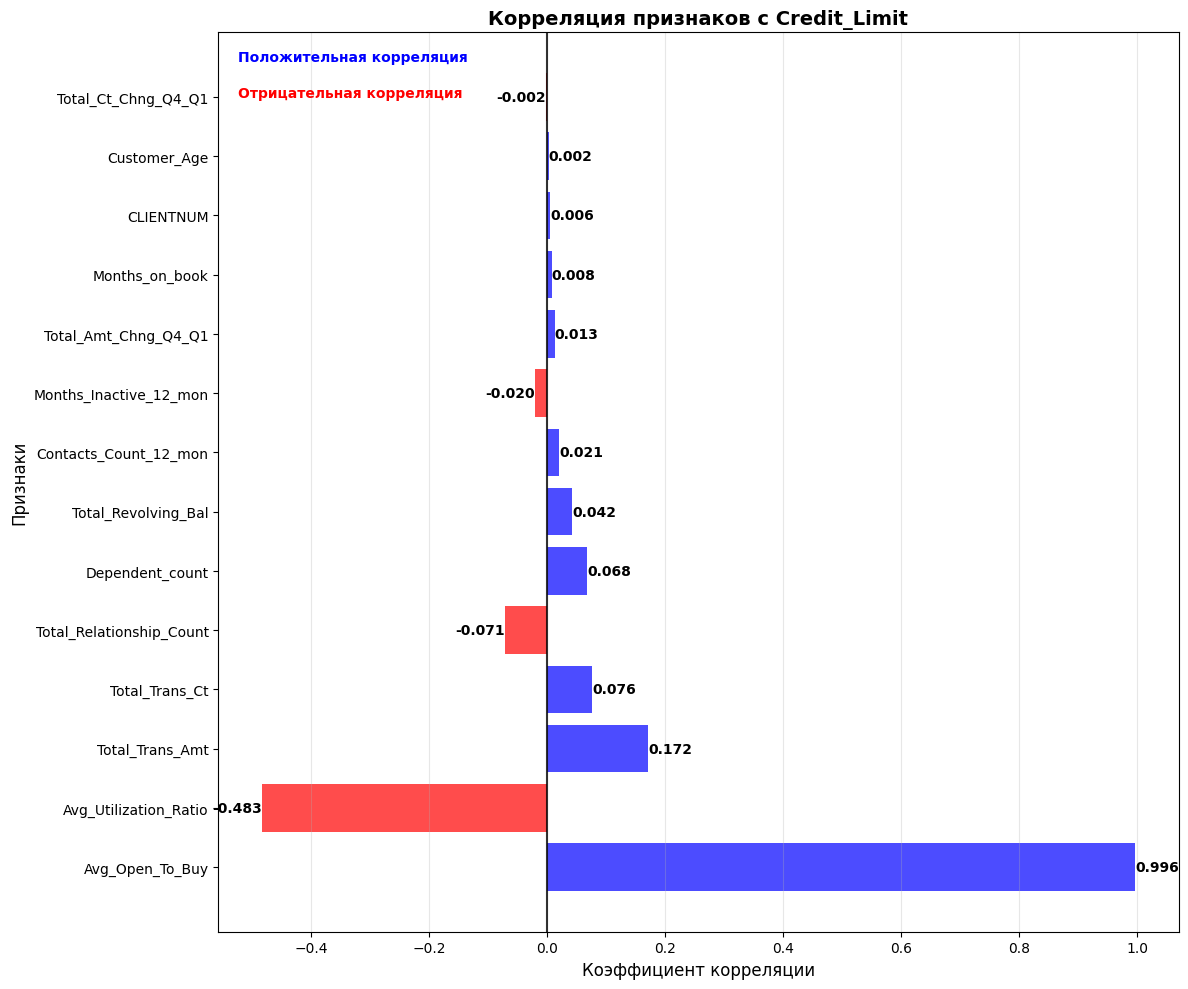


Топ-10 признаков по корреляции с Credit_Limit:
 1. Avg_Open_To_Buy          :   0.996
 2. Avg_Utilization_Ratio    :  -0.483
 3. Total_Trans_Amt          :   0.172
 4. Total_Trans_Ct           :   0.076
 5. Total_Relationship_Count :  -0.071
 6. Dependent_count          :   0.068
 7. Total_Revolving_Bal      :   0.042
 8. Contacts_Count_12_mon    :   0.021
 9. Months_Inactive_12_mon   :  -0.020
10. Total_Amt_Chng_Q4_Q1     :   0.013
Удаляем ненужные (не используются при анализе) колонки из копии, чтобы выводить их при визуализации датасета
Удаляем Avg_Open_To_Buy из-за кореляции с Credit_Limit
Удален столбец: CLIENTNUM
Удален столбец: Attrition_Flag
Удален столбец: Avg_Open_To_Buy
Удаляем выбросы по Credit_Limit, Avg_Utilization_Ratio, Total_Revolving_Bal, Total_Trans_Amt, Total_Trans_Ct
Признаки: (8420, 17), Целевая: (8420,)
Визуализация целевой переменной


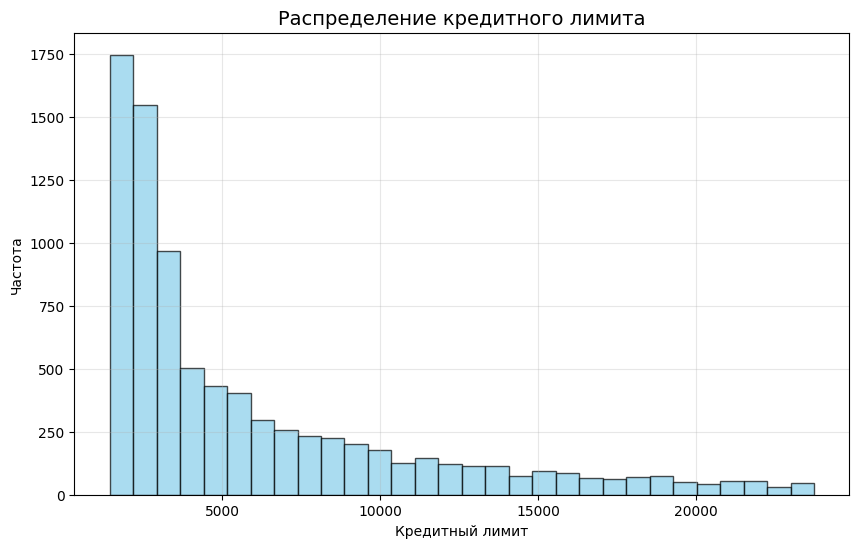


Обучение линейной регрессии...

=== Оценка линейной регрессии ===
Среднеквадратичная ошибка (MSE): 11256493.35
Корень из MSE (RMSE): 3355.07
Средняя абсолютная ошибка (MAE): 2480.53
Коэффициент детерминации R²: 0.5556
======== Коэффициенты линейной регрессии ===================
 1. Avg_Utilization_Ratio    : -4308.6310
 2. Total_Revolving_Bal      :  3176.5031
 3. Gender                   :  1134.9481
 4. Card_Category            :   774.9286
 5. Income_Category          :   227.4772
 6. Total_Relationship_Count :   153.1520
 7. Customer_Age             :   130.2299
 8. Dependent_count          :   117.6703
 9. Total_Trans_Ct           :    86.8004
10. Months_on_book           :   -75.2454
11. Total_Trans_Amt          :    67.9524
12. Education_Level          :    57.6724
13. Marital_Status           :    55.0087
14. Total_Amt_Chng_Q4_Q1     :    36.5575
15. Months_Inactive_12_mon   :    26.3509
16. Total_Ct_Chng_Q4_Q1      :    26.3318
17. Contacts_Count_12_mon    :    16.3489


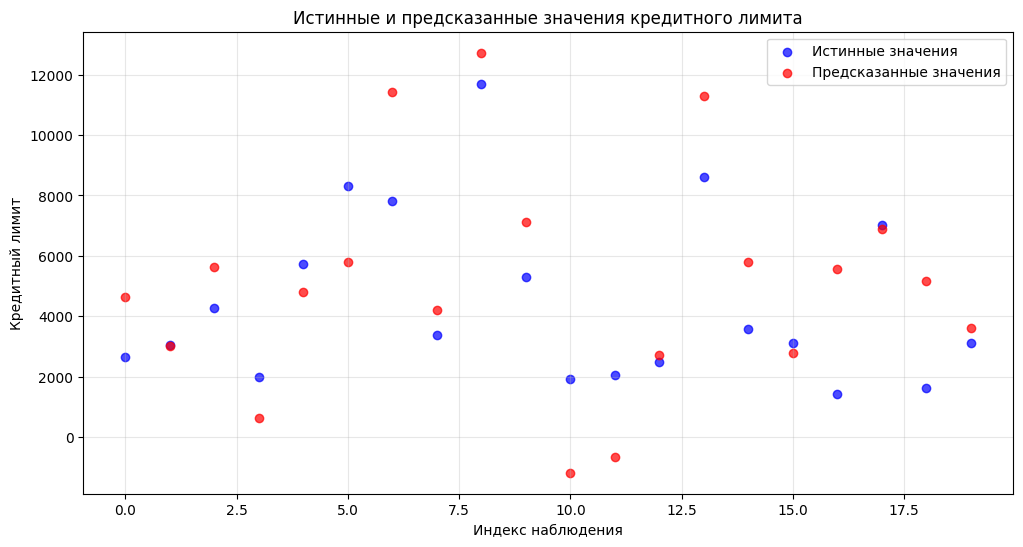

Анализ завершен!


In [1]:
import data_loader
import data_processing
import ml_module
import visualization
import pandas as pd
import numpy as np

def main():
    print("ПРОГНОЗИРОВАНИЕ КРЕДИТНОГО ЛИМИТА")
    print("=" * 60)

    # Загрузка данных
    df = data_loader.load_credit_card_data('BankChurners.csv')

    # Удаляем колонки, которые в описании датасета рекрмендуют удалить до исследования (не будем их визуализировать даже для анализа)
    print('Удаляем колонки, которые в описании датасета рекрмендуют удалить до исследования (не будем их визуализировать даже для анализа)')
    cols_to_drop = [
        'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
        'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2',
    ]
    for col in cols_to_drop:
        if col in df.columns:
            df.drop(col, axis=1, inplace=True)
            print(f"Удален столбец: {col}")

    if df is None:
        print("Скачайте датасет: https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers")
        return

    # Исследование данных
    data_processing.explore_data(df)

    # Анализ корреляции перед обработкой
    print("\nАНАЛИЗ КОРРЕЛЯЦИИ С CREDIT_LIMIT:")
    print("=" * 60)

    # Построим график корреляции с целевой переменной
    visualization.plot_correlation_with_target(df, 'Credit_Limit')

    # Подготовка данных
    X, y = data_processing.prepare_data(df)
    if X is None or y is None:
        return

    # Визуализация целевой переменной
    print('='*60)
    print('Визуализация целевой переменной')
    visualization.plot_histogram(y, 'Распределение кредитного лимита', 'Кредитный лимит', 'Частота')

    # Разделение данных
    X_train, X_test, y_train, y_test = ml_module.split_data(X, y)

    # Масштабирование признаков
    X_train_scaled, X_test_scaled, scaler = ml_module.scale_features(X_train, X_test)

    # Обучение модели
    print()
    print('=' * 60)
    print("Обучение линейной регрессии...")
    model = ml_module.train_linear_regression(X_train_scaled, y_train)
    print('=' * 60)
    print()

    # Предсказание
    y_pred = ml_module.predict(model, X_test_scaled)

    # Оценка модели
    metrics = ml_module.evaluate_model(y_test, y_pred)

    # Коэффициенты модели
    coefficients = ml_module.get_coefficients(model, X.columns.tolist())
    ml_module.print_coefficients(coefficients)

    # Визуализация результатов
    visualization.plot_predictions(y_test, y_pred)

    print("Анализ завершен!")

if __name__ == "__main__":
    main()